***
***
<span style="font-size: 28pt"> <span style="color:blue">
    **Step.3.2_scvelo steady state model on Cells**
    </span><br>
 
***


# set up the packages

In [1]:
import scvelo as scv
scv.logging.print_version()

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization


Running scvelo 0.2.2 (python 3.6.10) on 2021-03-15 12:27.


# read data from previously saved merged loom file

This taks from 9:50 to 

In [2]:
import pickle
# with open('../ProcessedData/merged_umap5_cells.pickle', 'wb') as f:
#     pickle.dump(adata, f)
with open('../ProcessedData/merged_cells.pickle',"rb") as f:
    adata = pickle.load(f)

In [6]:
# show proportions of spliced/unspliced abundances
scv.utils.show_proportions(adata)

Abundance of ['spliced', 'unspliced']: [0.8 0.2]


If you have a very large datasets, you can save memory by clearing attributes not required via `scv.utils.cleanup(adata)`.

## Preprocess the data

Preprocessing that is necessary consists of :
- gene selection by **detection** (detected with a minimum number of counts) and **high variability** (dispersion).
- **normalizing** every cell by its initial size and **logarithmizing** X.

Filtering and normalization is applied in the same vein to spliced/unspliced counts and X.
Logarithmizing is only applied to X. <br>If X is already preprocessed from former analysis, it won't touch it.

All of this is summarized in a single function `pp.filter_and_normalize`, which basically runs the following:

```
scv.pp.filter_genes(adata, min_shared_counts=10)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=3000)
scv.pp.log1p(adata)
```
<span style="font-size: 10pt"> <span style="color:blue">
Further, we need the **first and second order moments** (basically mean and uncentered variance) computed among nearest neighbors in PCA space.<br> 
First order is needed for deterministic velocity estimation, while stochastic estimation also requires second order moments.
    </span><br>

this step take from 2:07--2:12pm, 5 minutes

In [7]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)


Filtered out 1516 genes that are detected 30 counts (shared).
Normalized count data: spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:31) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Compute velocity and velocity graph
The gene-specific velocities are obtained by fitting a ratio between precursor (unspliced) and mature (spliced) mRNA abundances that well explains the steady states (constant transcriptional state) and then computing how the observed abundances deviate from what is expected in steady state. 
## (**We will soon release a version that does not rely on the steady state assumption anymore**).

Every tool has its plotting counterpart. The results from `scv.tl.velocity`, for instance, can be visualized using `scv.pl.velocity`.

In [8]:
scv.tl.velocity

<function scvelo.tools.velocity.velocity(data, vkey='velocity', mode='stochastic', fit_offset=False, fit_offset2=False, filter_genes=False, groups=None, groupby=None, groups_for_fit=None, constrain_ratio=None, use_raw=False, use_latent_time=None, perc=[5, 95], min_r2=0.01, min_likelihood=0.001, r2_adjusted=None, diff_kinetics=None, copy=False, **kwargs)>

In [9]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:22) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


<span style="font-size: 10pt"> <span style="color:blue">
This computes the (cosine) correlation of potential cell transitions with the velocity vector in high dimensional space.<br>
The resulting velocity graph has dimension $n_{obs} \times n_{obs}$ and summarizes the possible cell state changes (given by a transition from one cell to another) that are well explained through the velocity vectors. <br>If you set `approx=True` it is computed on a reduced PCA space with 50 components. 
The velocity graph can then be converted to a transition matrix by applying a Gaussian kernel on the cosine correlation which assigns high probabilities to cell state changes that correlate with the velocity vector. You can access the Markov transition matrix via `scv.tl.transition_matrix`.<br> The resulting transition matrix can be used for a variety of applications shown hereinafter. For instance, it is used to place the velocities into a low-dimensional embedding by simply applying the mean transition with respect to the transition probabilities, i.e. `scv.tl.velocity_embedding`. <br>Further, we can trace cells back along the Markov chain to their origins and potential fates, thus obtaining root cells and end points within a trajectory; via `scv.tl.terminal_states`.    
</span><br>

2:12pm -- 2:13pm

In [10]:
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:04:17) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


# Plot results

Finally, the velocities are projected onto any embedding specified in `basis` and visualized in one of three available ways: on single cell level, on grid level, or as streamplot as shown here.

 strange, even though I have the umap coordinate, there is still problem with get the X_umap.<br>
ref: https://github.com/theislab/scvelo/issues/170

## run a umap internal of python

In [11]:
scv.tl.umap(adata)

## stream plots

Renamed 'umap_cell_embeddings' to convention 'X_umap_cell_embeddings' (adata.obsm).
computing velocity embedding
    finished (0:00:12) --> added
    'velocity_umap_cell_embeddings', embedded velocity vectors (adata.obsm)


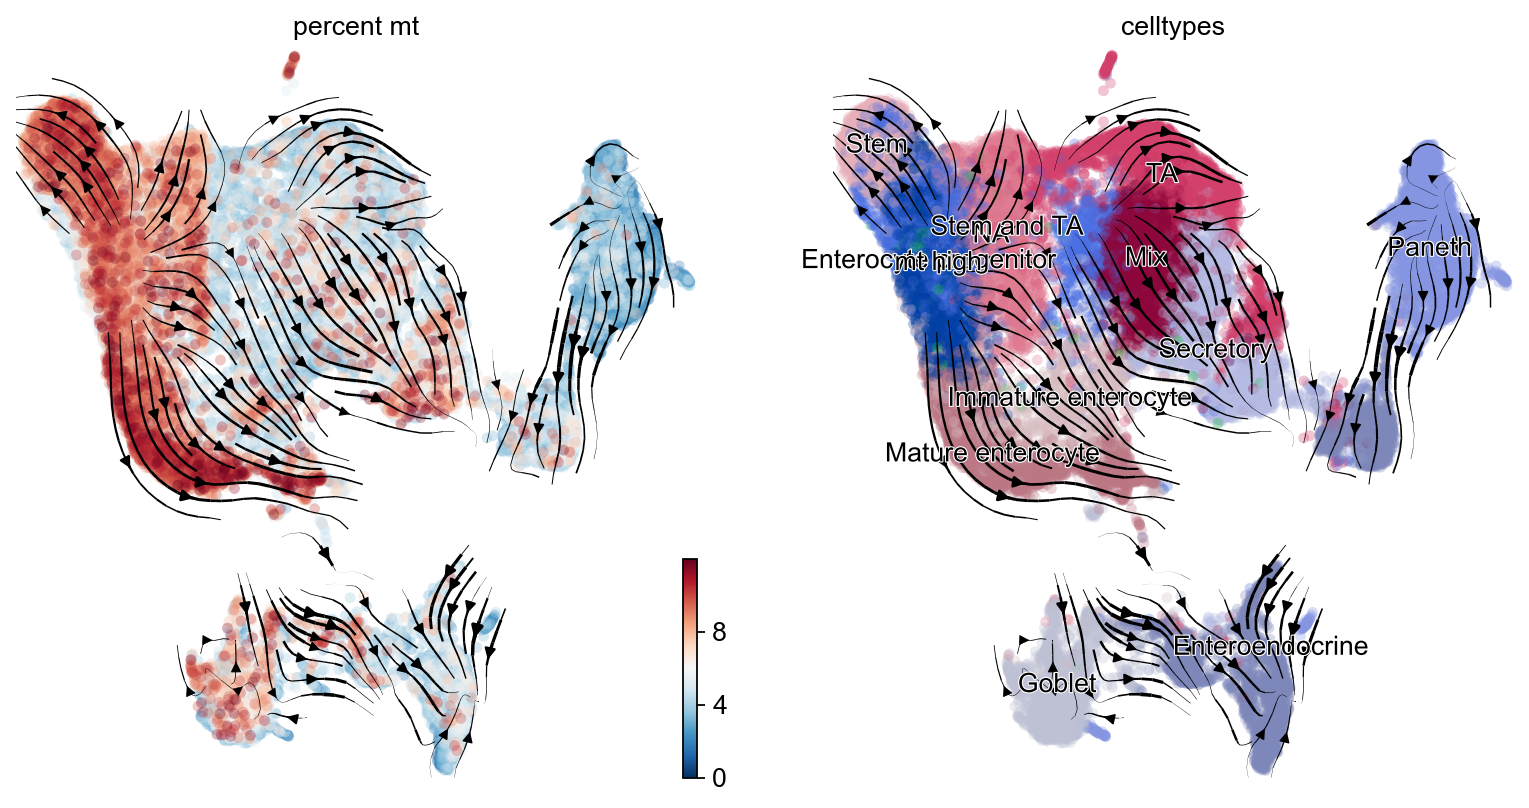

In [12]:
scv.pl.velocity_embedding_stream(adata, basis='umap_cell_embeddings', figsize=(8,8),color=['percent_mt','celltypes'],legend_fontweight=1)

computing velocity embedding
    finished (0:00:11) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


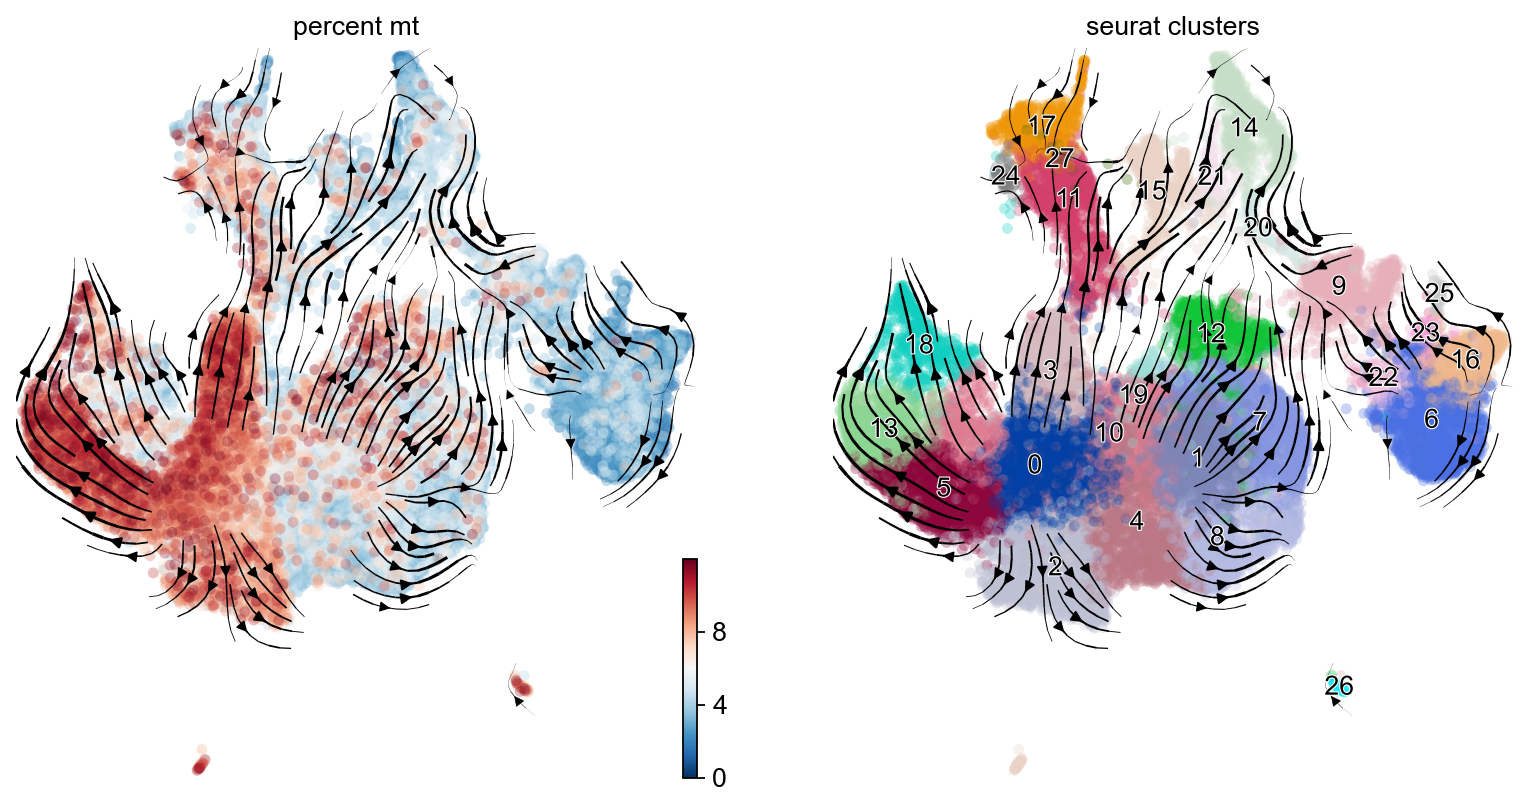

In [13]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color=['percent_mt','seurat_clusters'],figsize=(8,8),legend_fontweight=1)


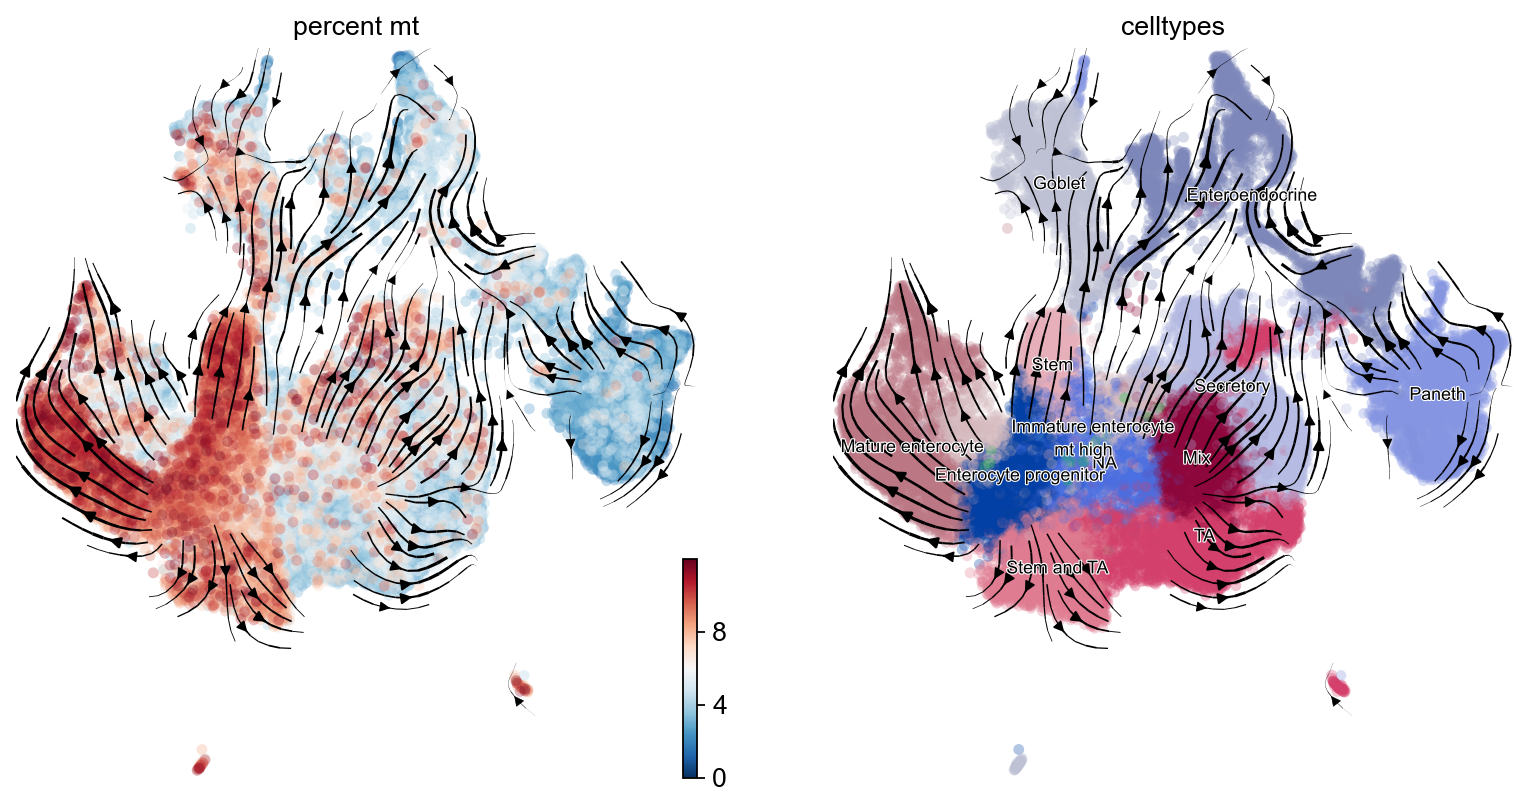

In [14]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color=['percent_mt',"celltypes"],legend_fontsize=8,
                                 figsize=(8,8),legend_fontweight=1)

In [15]:
#?scv.pl.velocity_embedding_stream

## grid plot

In [3]:
scv.pl.velocity_embedding_grid(adata, color='latent_time', basis='umap_cell_embeddings',arrow_length =8,
                               layer=['velocity', 'spliced'], arrow_size=1, figsize=(8,5),save = 'Seurat_umap_overlaySeuratClusters.pdf')


In [ ]:
scv.pl.velocity_embedding_grid(adata, color='Myb', basis='umap_cell_embeddings',arrow_length =8,
                               layer=['velocity', 'spliced'], arrow_size=1, figsize=(8,5),save = 'Seurat_umap_overlaySeuratClusters.pdf')

# Explore velocity genes

## rank velocity genes by clusters identified with scv.tl.umap() function

In [ ]:
scv.tl.rank_velocity_genes(adata, groupby='seurat_clusters')
scv.DataFrame(adata.uns['rank_velocity_genes']['names']).head()


In [ ]:
scv.tl.rank_velocity_genes(adata, groupby='Clusters')
scv.DataFrame(adata.uns['rank_velocity_genes']['names']).head()

## rank velocity genes by clusters identified with Seurat pipeline

In [ ]:
scv.tl.rank_velocity_genes(adata, groupby='seurat_clusters')
scv.DataFrame(adata.uns['rank_velocity_genes']['names']).head()


In [ ]:
# var_names = ['2810417H13Rik','Wfdc17','Il22','Cxcl10','Cst3','Ly6d','Ifitm3','Apoe','Retnlg','Ly6i','Tyrobp','Ifitm2']
# scv.pl.velocity(adata, var_names=var_names, colorbar=True, ncols=2, basis='umap_cell_embeddings',figsize=(8,6),mode=None)
# #,save = 'VelocityDriversGOI_expression.png')

In [ ]:
import pickle
with open('../ProcessedData/Steady_merged_cells.pickle', 'wb') as f:
    pickle.dump(adata, f)